In [69]:
# import all the libraries
from collections import defaultdict
import string
import os
import torch
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn

In [70]:
# loading the file, reading the content, and ordering them based on the image file.
def load_file(path: str):
    file = open(path, 'r')
    text = file.read()
    file.close()
    return text

def get_data(file_path: str) -> dict[str, [str]]:
    text = load_file(file_path)
    data = text.split('\n')
    img_cap_dict = defaultdict(list)
    for line in data:
        line.strip()
        if not line:
            continue
        if '\t' in line:
            img, caption = line.split('\t')
        else:
            content = line.split(maxsplit=1)
            if len(content) > 2:
                continue
            else:
                print(content)
                img, caption = content[0], content[1]
                
        img = img.split('#', 1)[0].strip()
        img_cap_dict[img].append(caption)
    return img_cap_dict

img_cap_dict = get_data('./data/Flickr8k.token.txt')  


In [71]:
# data preprocessing - lowercase, adding <start> and <end> tokens, removing punctuations, removing numericals

def process_data(data):
    translator = str.maketrans('', '', string.punctuation)
    for k in data.keys():
        values = data[k]
        for i, v in enumerate(values):
            # convert to lowercase
            v = v.lower()
            # remove punctuation
            v = v.translate(translator)
            # remove numbers
            v =  v.split()
            v = [w for w in v if w.isalpha()]
            # remove wierd words
            # v = [w for w in v if (len(w)>1)]
            if len(v) > 0:
                v = ['<start>'] + v + ['<end>']
            v = " ".join(v)
            data[k][i] = v
    return data
img_cap_dict = process_data(img_cap_dict)
m = 0
for k in img_cap_dict.keys():
    for v in img_cap_dict[k]:
        m = max(len(v), m)
m
# max lenght is 210 characters, can use it for sequence generation
        

206

In [72]:
# now the tokenization part, lets build a custom function for tokenization

def build_vocab_freq(caption_tokens):
    vocab_freq = defaultdict(int)
    for caption_token in caption_tokens:
        for w in caption_token:
            vocab_freq[w] += 1
    # print('len of vocab freq:::', len(vocab_freq))
    # print(vocab_freq)
    return vocab_freq

def tokenize(captions):
    caption_tokens = []
    for c in captions:
        caption_tokens.append(c.split())
    return caption_tokens

def remove_less_frequent(vocab_freq, min_freq=3, keep_tokens=("<start>", "<end>", "<pad>", "<unk>")):
    keep = set(keep_tokens)
    return {w: f for w, f in vocab_freq.items() if (f >= min_freq) or (w in keep)}

captions = []
for k in img_cap_dict.keys():
    for c in img_cap_dict[k]:
        captions.append(c)

caption_tokens = tokenize(captions)
vocab_freq = build_vocab_freq(caption_tokens)
# vocab_freq = remove_less_frequent(vocab_freq)



In [73]:
# now assign a unique id to all the words, add <pad> and <unk>
def assign_ids(vocab_freq):
    wtoi = {'<pad>': 0, '<unk>': 1}
    itow = {0: '<pad>', 1: '<unk>'}
    
    # Deterministic ordering: by frequency desc, then alphabetically
    words = sorted(vocab_freq.items(), key=lambda x: (-x[1], x[0]))
    for idx, (w, _) in enumerate(words, start=2):
        if w in wtoi:   # don't re-add specials if present
            continue
        wtoi[w] = idx
        itow[idx] = w
    return wtoi, itow

wtoi, itow = assign_ids(vocab_freq)

# print("vocab size:", len(wtoi))
# print({k: wtoi[k] for k in ['<pad>', '<unk>', '<start>', '<end>'] if k in wtoi})
# print(wtoi)

In [74]:
# pending part is to read images and get the image features, then use encodings to get the embeddgins to input captions, we feed 
# the input features and embeddings to a LSTM model. Let's do this tomorrow!!!

import numpy as np

# caption_tokens is a list of lists, e.g. [["<start>", "a", ... , "<end>"], ...]
lengths = np.array([len(tokens) for tokens in caption_tokens], dtype=np.int32)

# get the precentile lengths and assign the seq lenght as the 99th precentile length
p95 = int(np.ceil(np.percentile(lengths, 95)))
p99 = int(np.ceil(np.percentile(lengths, 99)))
print("p99_int:", p99)

max_len = p99


p99_int: 24


In [75]:
resnet50_weights = ResNet50_Weights.DEFAULT
image_feature_ext_model = resnet50(weights=resnet50_weights)
preprocess = resnet50_weights.transforms()
image_feature_ext_model.fc = nn.Identity()

# Define the device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Mac GPU)")
else:
    device = torch.device("cpu")
    print("MPS not available, using CPU")

image_feature_ext_model.to(device)
image_feature_ext_model.eval()

def extract_image_features(image_features, images_directory='./data/images/'):
    images = os.listdir(images_directory)
    allowed_ext = {'.jpg', '.jpeg', '.png'}
    for img in images:
        ext = os.path.splitext(img)[1].lower()
        if ext not in allowed_ext:
            continue
        image_dir = os.path.join(images_directory, img)
        image = Image.open(image_dir).convert('RGB')
        image = preprocess(image)
        image = image.unsqueeze(0).to(device)
        with torch.no_grad():
            feature = image_feature_ext_model(image)
            feature = feature.squeeze(0).cpu()
            image_features[img] = feature

IMAGE_PATH = './data/images/'
FEATURES_PATH = './data/image_featuers_resent50.pt'

image_features = {}
if os.path.exists(FEATURES_PATH):
    image_features = torch.load(FEATURES_PATH, map_location="cpu")
    print("loading the image features from saved files")
else:
    image_features = {}
    extract_image_features(image_features, IMAGE_PATH)
    torch.save(image_features, FEATURES_PATH)

# extract_image_features(image_features)
print(len(image_features), next(iter(image_features.values())).shape)
print("Loaded features:", len(image_features))
print("One feature shape:", next(iter(image_features.values())).shape)
print("inspecg a image feature", image_features['3569329986_1f468729b2.jpg'])
        
        
        

Using MPS (Mac GPU)
loading the image features from saved files
8091 torch.Size([2048])
Loaded features: 8091
One feature shape: torch.Size([2048])
inspecg a image feature tensor([0.0043, 0.0000, 0.1290,  ..., 0.0000, 0.0000, 0.2587])


In [80]:
import torch
from torch.utils.data import Dataset, DataLoader

class ImageCaptionDataset(Dataset):
    def __init__(self, pairs, image_features, wtoi, max_len = 24):
        self.pairs = pairs
        self.feature_store = image_features
        self.wtoi = wtoi
        self.max_len = max_len
        self.pad_id = wtoi["<pad>"]
        self.unk_id = wtoi["<unk>"]

    def __len__(self):
        return len(self.pairs)

    def to_ids(self, caption_tokens):
        ids = []
        caption_tokens = caption_tokens.split()
        for token in caption_tokens:
            ids.append(self.wtoi.get(token, self.unk_id))
        return ids

    def __getitem__(self, idx):
        # image_id, input_tokens, output_token = self.pairs[idx]
        image_id, input_tokens = self.pairs[idx]
        ids = self.to_ids(input_tokens)
        image_feature = self.feature_store[image_id]

        # input/target shift
        input_ids = ids[:-1]
        target_ids = ids[1:]

        # truncate to max_len
        input_ids = input_ids[:self.max_len]
        target_ids = target_ids[:self.max_len]


        # padding
        pad_needed = self.max_len - len(input_ids)
        if pad_needed > 0:
            input_ids += [self.pad_id] * pad_needed
            target_ids += [self.pad_id] * pad_needed

        lengths = min(len(ids) - 1, self.max_len)
        
        return (
            image_feature,
            torch.tensor(input_ids, dtype=torch.long),
            torch.tensor(target_ids, dtype=torch.long),
            torch.tensor(lengths, dtype=torch.long)
        )
#load the data 
def load_photos(filename):
    file = load_file(filename)
    photos = file.split("\n")[:-1]
    photos_present = [
        p for p in photos
        if os.path.exists(os.path.join(IMAGE_PATH, p))
        and p in image_features           # <-- important
        and p in img_cap_dict             # <-- also important
    ]
    return photos_present

def construct_data_for_model(pairs):
    data_format_for_model = []
    for img_fe, caps in pairs:
        caps_token = caps.split()
        # print(caps_token)
        # return
        for i in range(1, len(caps_token)):
            data_format_for_model.append((img_fe, caps_token[:i], caps_token[i]))
    return data_format_for_model


train_images = set(load_photos('./data/Flickr_8k.trainImages.txt'))
dev_images = set(load_photos('./data/Flickr_8k.devImages.txt'))

train_pairs = [
    (image_id, cap)
    for image_id, captions in img_cap_dict.items()
    if image_id in train_images
    for cap in captions
]
# train_pairs = construct_data_for_model(train_pairs)

dev_pairs = [
    (image_id, cap)
    for image_id, captions in img_cap_dict.items()
    if image_id in dev_images
    for cap in captions
]
# dev_pairs = construct_data_for_model(dev_pairs)


train_dataset = ImageCaptionDataset(train_pairs, image_features, wtoi, 24)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

dev_dataset = ImageCaptionDataset(dev_pairs, image_features, wtoi, 24)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False, num_workers=0)

# One batch
image_feats, input_ids, target_ids, lengths = next(iter(train_loader))
print(image_feats.shape, input_ids.shape, target_ids.shape, lengths.shape)
print("Dev images:", len(dev_images))
print("Dev pairs:", len(dev_pairs))




torch.Size([32, 2048]) torch.Size([32, 24]) torch.Size([32, 24]) torch.Size([32])
Dev images: 1000
Dev pairs: 5000


In [81]:
import math
import torch

class CaptioningModel(nn.Module):
    def __init__(self, vocab_size, emb_dim, image_input = 2048, pad_id = 0, dropout = 0.5):
        super().__init__()
        # for image, convert from 2048 to emb_dim
        self.image_dropout = nn.Dropout(0.2)
        self.lin_image_h1 = nn.Linear(image_input, emb_dim)
        self.lin_image_c1 = nn.Linear(image_input, emb_dim)
        self.norm = nn.LayerNorm(emb_dim)

        # for caption layer
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_id)
        self.embed_drop = nn.Dropout(dropout)
        self.lstm = nn.LSTM(emb_dim, emb_dim, batch_first=True)

        # adding CNN and LSTM layers to two more dense layers with relu and softmax
        self.cnn_lstm_lin = nn.Linear(emb_dim, emb_dim)
        self.relu = nn.ReLU()
        self.out = nn.Linear(emb_dim, vocab_size)

    def forward(self, image_feat, input_ids, lengths):
        B = input_ids.size(0)
        # d_i = self.image_dropout(image_feat)
        
        h0 = self.norm(self.lin_image_h1(image_feat)).unsqueeze(0)
        c0 = self.norm(self.lin_image_c1(image_feat)).unsqueeze(0)

        caption_embeds = self.embed(input_ids)
        caption_embeds = self.embed_drop(caption_embeds)
        out_seq, (hn, _) = self.lstm(caption_embeds, (h0, c0))             # hn: (1, B, 256) for 1-layer
         
        # Pick hidden at last real token per sample: out_seq[b, lengths[b]-1]
        # idx = (lengths - 1).clamp(min=0)                       # (B,)
        # se_last = out_seq[torch.arange(B, device=input_ids.device), idx]  # (B, E)
        # c = hn[-1] 

        # merged_inputs = x + se_last
        # out = self.relu(self.cnn_lstm_lin(merged_inputs))
        out = self.out(out_seq)
        return out

def run_model(model, loss_fn, loader, optimizer=None, device = 'cpu'):

    is_train = optimizer is not None

    if is_train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    correct = 0
    total = 0


    context = torch.enable_grad() if is_train else torch.no_grad()
    with context:
        for image_feat, input_ids, target_ids, lengths in loader:
            image_feat = image_feat.to(device)
            input_ids = input_ids.to(device)
            target_ids = target_ids.to(device)
            lengths = lengths.to(device)
    
            logits = model(image_feat, input_ids, lengths)
            logits_2d = logits.reshape(-1, logits.size(-1))
            targets_1d = target_ids.reshape(-1)
            loss = loss_fn(logits_2d, targets_1d)


            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            preds = logits.argmax(dim=-1)
            mask = target_ids != pad_id
            correct += (((preds == target_ids) & mask).sum().item())
            total += mask.sum().item()
            total_loss += loss.item()
            


    avg_loss = total_loss / max(len(loader), 1)
    acc = correct / max(total, 1)
    return avg_loss, acc

vocab_size = len(wtoi)
emb_dim = 256
pad_id = wtoi["<pad>"]
MODEL_SAVE_PATH = './data/model/best_model.pt'

model = CaptioningModel(
    vocab_size,
    emb_dim,
    image_input=2048,
    pad_id=wtoi["<pad>"],
    dropout=0.4
).to(device)

loss = nn.CrossEntropyLoss(ignore_index=pad_id)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


epochs = 20
best_val_loss = float("inf")

for epoch in range(epochs):
    train_loss, train_acc = run_model(model, loss, train_loader,  optimizer, device)
    val_loss, val_acc = run_model(model, loss, dev_loader, None, device)

    # save if this is the best validation loss so far
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     best_epoch = epoch + 1
    #     torch.save({
    #         "epoch": best_epoch,
    #         "model_state_dict": model.state_dict(),
    #         "optimizer_state_dict": optimizer.state_dict(),
    #         "val_loss": best_val_loss,
    #         "wtoi": wtoi,   # optional but useful for later inference
    #         "emb_dim": emb_dim,
    #         "vocab_size": vocab_size,
    #     }, MODEL_SAVE_PATH)

    
    print(
        f"Epoch {epoch+1:02d}/{epochs} | "
        f"train loss: {train_loss:.4f} | train acc: {train_acc:.3f} | "
        f"val loss: {val_loss:.4f} | val acc: {val_acc:.3f}"
    )
        
    

Epoch 01/20 | train loss: 5.2276 | train acc: 0.210 | val loss: 4.5138 | val acc: 0.262
Epoch 02/20 | train loss: 4.2294 | train acc: 0.290 | val loss: 4.0994 | val acc: 0.304
Epoch 03/20 | train loss: 3.8786 | train acc: 0.326 | val loss: 3.8616 | val acc: 0.327
Epoch 04/20 | train loss: 3.6384 | train acc: 0.349 | val loss: 3.7054 | val acc: 0.341
Epoch 05/20 | train loss: 3.4560 | train acc: 0.368 | val loss: 3.5982 | val acc: 0.349
Epoch 06/20 | train loss: 3.3081 | train acc: 0.383 | val loss: 3.5182 | val acc: 0.354
Epoch 07/20 | train loss: 3.1828 | train acc: 0.395 | val loss: 3.4567 | val acc: 0.360
Epoch 08/20 | train loss: 3.0758 | train acc: 0.406 | val loss: 3.4082 | val acc: 0.362
Epoch 09/20 | train loss: 2.9834 | train acc: 0.415 | val loss: 3.3707 | val acc: 0.365
Epoch 10/20 | train loss: 2.8993 | train acc: 0.424 | val loss: 3.3435 | val acc: 0.368
Epoch 11/20 | train loss: 2.8236 | train acc: 0.432 | val loss: 3.3169 | val acc: 0.368
Epoch 12/20 | train loss: 2.7544

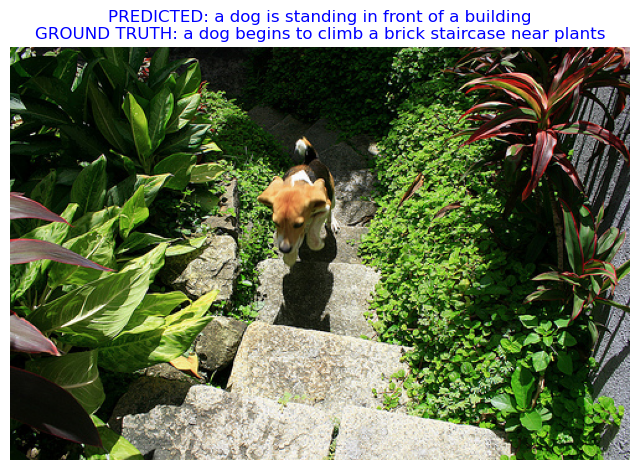

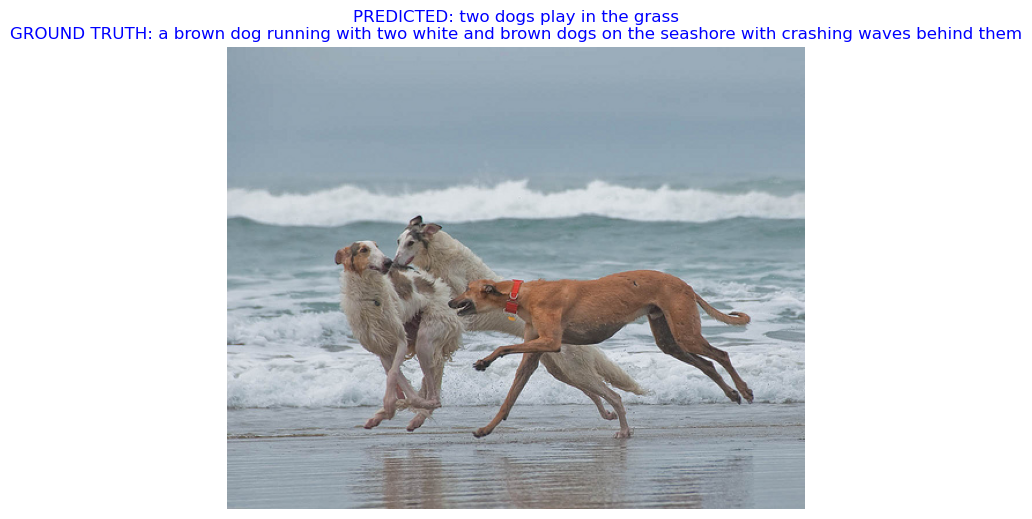

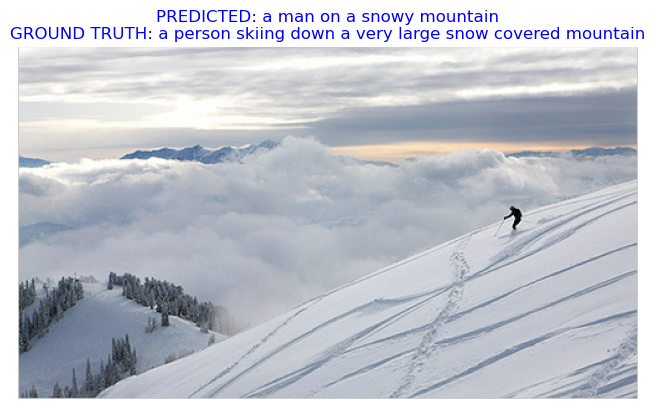

In [90]:
import matplotlib.pyplot as plt
import random
from PIL import Image

import torch
import torch.nn as nn

def beam_search(model, image_feat, wtoi, itow, beam_width=3, max_len=24):
    model.eval()
    device = next(model.parameters()).device
    
    with torch.no_grad():
        # 1. Initialize hidden states from image
        image_feat = image_feat.to(device).unsqueeze(0)
        h = model.norm(model.lin_image_h1(image_feat)).unsqueeze(0)
        c = model.norm(model.lin_image_c1(image_feat)).unsqueeze(0)
        
        # Each "beam" is (cumulative_log_prob, word_list, hidden_state)
        # Start with the <start> token
        start_id = wtoi['<start>']
        beams = [(0.0, [start_id], (h, c))]
        
        for _ in range(max_len):
            new_beams = []
            
            for log_prob, words, hidden in beams:
                # If the last word was <end>, keep the beam as is
                if words[-1] == wtoi['<end>']:
                    new_beams.append((log_prob, words, hidden))
                    continue
                
                # Get prediction for the last word in the list
                curr_word = torch.tensor([[words[-1]]], device=device)
                embedded = model.embed(curr_word)
                output, next_hidden = model.lstm(embedded, hidden)
                logits = model.out(output.squeeze(1)) # (1, vocab_size)
                
                # Get log probabilities
                log_probs = torch.log_softmax(logits, dim=-1)
                
                # Find the top k candidates for this beam
                top_probs, top_ids = torch.topk(log_probs, beam_width, dim=-1)
                
                for i in range(beam_width):
                    new_log_prob = log_prob + top_probs[0][i].item()
                    new_words = words + [top_ids[0][i].item()]
                    new_beams.append((new_log_prob, new_words, next_hidden))
            
            # Sort all candidate beams by probability and keep top 'beam_width'
            beams = sorted(new_beams, key=lambda x: x[0], reverse=True)[:beam_width]
            
            # If all beams have reached <end>, stop early
            if all(b[1][-1] == wtoi['<end>'] for b in beams):
                break
                
        # Return the best sequence, stripping <start> and <end>
        best_words = beams[0][1]
        caption = [itow[i] for i in best_words if i not in [wtoi['<start>'], wtoi['<end>']]]
        return caption

def visualize_results(model, image_ids, image_features, img_cap_dict, wtoi, itow, n=3):
    sample_ids = random.sample(list(image_ids), n)
    
    for img_id in sample_ids:
        feat = image_features[img_id]
        prediction = beam_search(model, feat, wtoi, itow)
        
        # Load and show image
        img_path = f"./data/images/{img_id}"
        img = Image.open(img_path)
        
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis('off')
        
        pred_text = " ".join(prediction)
        real_text = img_cap_dict[img_id][0].replace('<start>', '').replace('<end>', '').strip()
        
        plt.title(f"PREDICTED: {pred_text}\nGROUND TRUTH: {real_text}", color='blue')
        plt.show()

# Usage:
visualize_results(model, dev_images, image_features, img_cap_dict, wtoi, itow)

In [91]:
from nltk.translate.bleu_score import corpus_bleu

def evaluate_bleu(model, image_ids, image_features, img_cap_dict, wtoi, itow):
    model.eval()
    references = []
    hypotheses = []
    
    print("Generating captions for evaluation...")
    for img_id in image_ids:
        # 1. Get references (remove special tokens for fair scoring)
        # Your dict has captions with <start> and <end>, we strip them
        raw_refs = img_cap_dict[img_id]
        cleaned_refs = [
            cap.replace('<start>', '').replace('<end>', '').strip().split() 
            for cap in raw_refs
        ]
        references.append(cleaned_refs)
        
        # 2. Generate prediction
        feat = image_features[img_id]
        prediction = beam_search(model, feat, wtoi, itow)
        hypotheses.append(prediction)
        
    # Calculate Scores
    # Weights for B1: (1,0,0,0), B2: (0.5,0.5,0,0), etc.
    b1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
    b2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
    b4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
    
    print(f"\n--- Evaluation Results ---")
    print(f"BLEU-1: {b1:.4f}")
    print(f"BLEU-2: {b2:.4f}")
    print(f"BLEU-4: {b4:.4f}")
    return b4

# Usage:
evaluate_bleu(model, dev_images, image_features, img_cap_dict, wtoi, itow)

Generating captions for evaluation...

--- Evaluation Results ---
BLEU-1: 0.6247
BLEU-2: 0.4329
BLEU-4: 0.1950


0.19504459962078735